# Great Expectations Analysis of CGN

## 1. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import great_expectations as gx
from great_expectations.data_context import data_context
from great_expectations.core.batch import BatchRequest
import pandas as pd
import os
from dotenv import load_dotenv


# Load environment variables
load_dotenv()  # Loads from .env by default

## Define base path (adjust if notebook is in different location)
BASE_PATH = os.getenv('BASE_PATH')

# Verify base path exists
if not BASE_PATH or not os.path.exists(BASE_PATH):
    raise ValueError(f"Invalid BASE_PATH: {BASE_PATH}. Check your .env file and directory structure")


# Define the project root directory
project_dir = os.path.join(BASE_PATH,"data/gx_bogota")  # Replace with your desired path

### Add Pandas Data Source

In [2]:
#Get the GX Context
context = gx.get_context(project_root_dir=project_dir)

# Verify active stores (e.g., Expectation Suites, Checkpoints)
print("Active Stores:", context.list_active_stores())

# Add a Pandas data source if not already present
try:
    data_source = context.data_sources.add_pandas("bogota_pandas_datasource")

    context.list_datasources()

except ValueError:
    print("Pandas data source already exists")

Active Stores: [{'class_name': 'ExpectationsStore', 'store_backend': {'class_name': 'TupleFilesystemStoreBackend', 'base_directory': 'expectations/'}, 'name': 'expectations_store'}, {'class_name': 'ValidationResultsStore', 'store_backend': {'class_name': 'TupleFilesystemStoreBackend', 'base_directory': 'uncommitted/validations/'}, 'name': 'validation_results_store'}, {'class_name': 'CheckpointStore', 'store_backend': {'class_name': 'TupleFilesystemStoreBackend', 'suppress_store_backend_id': True, 'base_directory': 'checkpoints/'}, 'name': 'checkpoint_store'}]


## 2. Add Data Asset and Batch

### Data Asset

In [3]:
data_asset_name = "cgn"
data_asset = data_source.add_dataframe_asset(name=data_asset_name)

### Data Batch

In [4]:
df = pd.read_parquet(os.path.join(BASE_PATH, 'data/1_Bronze/cgn.parquet'))

batch_definition = data_asset.add_batch_definition_whole_dataframe("CGN Data Dictionary")
batch_data = batch_definition.get_batch(batch_parameters={"dataframe": df})

In [5]:
context.list_datasources()

[{'type': 'pandas',
  'name': 'bogota_pandas_datasource',
  'id': UUID('3342c538-02ba-4a4b-80d5-4caa6351e0e4'),
  'assets': [{'name': 'cgn',
    'type': 'dataframe',
    'id': UUID('52236b7e-dbf2-4989-b17e-6aad699c254e'),
    'batch_metadata': {},
    'batch_definitions': [{'id': UUID('b193f037-4631-4eea-bb9e-b399e05d95cd'),
      'name': 'CGN Data Dictionary',
      'partitioner': None}]}]}]

## 3. Create Expectations

###  3.1 Codigo_Accidentado

In [6]:
# Initialize an empty list to store validation results
validation_results = []

# Example: Assuming 'batch_data' is already defined and contains your DataFrame

column = "Codigo contable"

# Expect Column to Exist
expectation = gx.expectations.ExpectColumnToExist(column=column)
validation_result = batch_data.validate(expectation)
validation_results.append({
    "expectation_type": "ExpectColumnToExist",
    "column": column,
    "success": validation_result.success,
    "unexpected_count": validation_result.result.get("unexpected_count", 0),
    "unexpected_percent": validation_result.result.get("unexpected_percent", 0.0)
})

# Expect Column Values to Not Be Null
expectation = gx.expectations.ExpectColumnValuesToNotBeNull(
    column=column, 
    mostly=1.0
)
validation_result = batch_data.validate(expectation)
validation_results.append({
    "expectation_type": "ExpectColumnValuesToNotBeNull",
    "column": column,
    "success": validation_result.success,
    "unexpected_count": validation_result.result.get("unexpected_count", 0),
    "unexpected_percent": validation_result.result.get("unexpected_percent", 0.0)
})

# Expect Column Values to Be of Type (int64)
expectation = gx.expectations.ExpectColumnValuesToBeOfType(
    column=column, 
    type_="int64"
)
validation_result = batch_data.validate(expectation)
validation_results.append({
    "expectation_type": "ExpectColumnValuesToBeOfType",
    "column": column,
    "success": validation_result.success,
    "unexpected_count": validation_result.result.get("unexpected_count", 0),
    "unexpected_percent": validation_result.result.get("unexpected_percent", 0.0)
})

# Expect Column Values to Be Between (100000 to 991590)
expectation = gx.expectations.ExpectColumnValuesToBeBetween(
    column=column,
    min_value=100000,
    max_value=991590
)
validation_result = batch_data.validate(expectation)
validation_results.append({
    "expectation_type": "ExpectColumnValuesToBeBetween",
    "column": column,
    "success": validation_result.success,
    "unexpected_count": validation_result.result.get("unexpected_count", 0),
    "unexpected_percent": validation_result.result.get("unexpected_percent", 0.0)
})

Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 1181.06it/s]


#### 3.1.1 Visualizing data

In [7]:
# Convert the list of validation results into a DataFrame
df_validation = pd.DataFrame(validation_results)

# Display the first few rows
df_validation.head()

,expectation_type,column,success,unexpected_count,unexpected_percent
0,ExpectColumnToExist,Codigo contable,True,0,0.0
1,ExpectColumnValuesToNotBeNull,Codigo contable,True,0,0.0
2,ExpectColumnValuesToBeOfType,Codigo contable,True,0,0.0
3,ExpectColumnValuesToBeBetween,Codigo contable,True,0,0.0


##### a. Success vs. Failure per Expectation Type

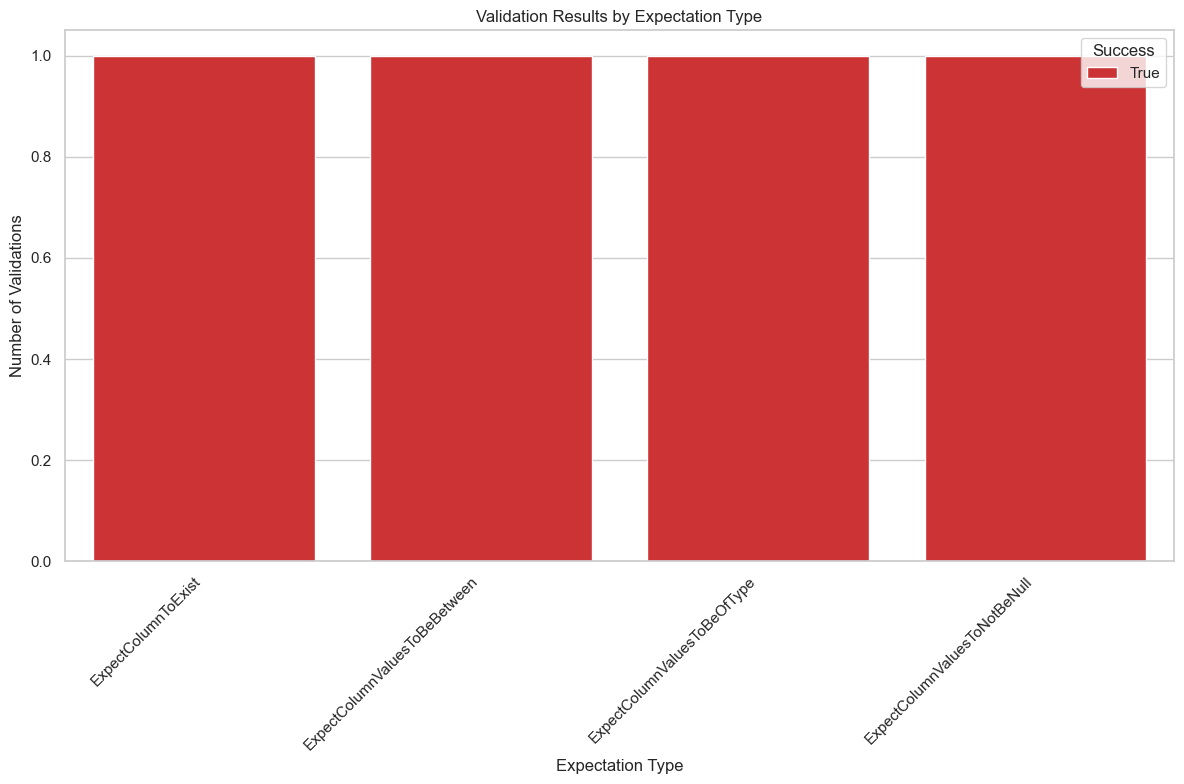

In [8]:
# Set plot style
sns.set(style="whitegrid")

# Create a pivot table for counts
pivot_df = df_validation.groupby(['expectation_type', 'success']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=pivot_df,
    x='expectation_type',
    y='count',
    hue='success',
    palette='Set1'
)
plt.title('Validation Results by Expectation Type')
plt.xlabel('Expectation Type')
plt.ylabel('Number of Validations')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Success')
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH,f"docs/validation_report/{data_asset_name}_{column}_validation_results_by_expectation_type.png"))
plt.show()


##### b. Overall Success Rate

Overall Success Counts:
success
True    4
Name: count, dtype: int64

Overall Success Index:
[True]

Generated Labels:
['Passed']


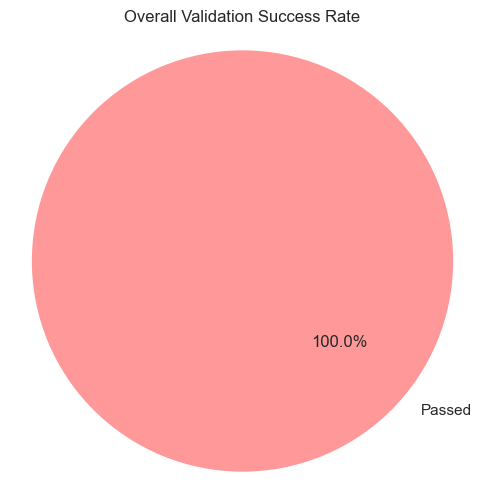

In [9]:
# Assuming 'df_validation' is your DataFrame with validation results
overall_success = df_validation['success'].value_counts()

# Print to inspect
print("Overall Success Counts:")
print(overall_success)
print("\nOverall Success Index:")
print(overall_success.index.tolist())

# Dynamically generate labels
labels = []
for label in overall_success.index:
    if label is True:
        labels.append('Passed')
    elif label is False:
        labels.append('Failed')
    else:
        labels.append(str(label))  # Handle unexpected labels

print("\nGenerated Labels:")
print(labels)

# Plot the pie chart with dynamic labels
plt.figure(figsize=(6,6))
plt.pie(
    overall_success,
    labels=labels,
    autopct='%1.1f%%',
    colors=['#FF9999','#99FF99','#CCCCCC'],  # Extend colors if needed
    startangle=140
)
plt.title('Overall Validation Success Rate')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig(os.path.join(BASE_PATH,f"docs/validation_report/{data_asset_name}_{column}_overall_success_rate.png"))
plt.show()


##### c. Success Rate per Column

/var/folders/76/q59sbk3j04d610g687pkcg2w0000gn/T/ipykernel_16207/2710655983.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


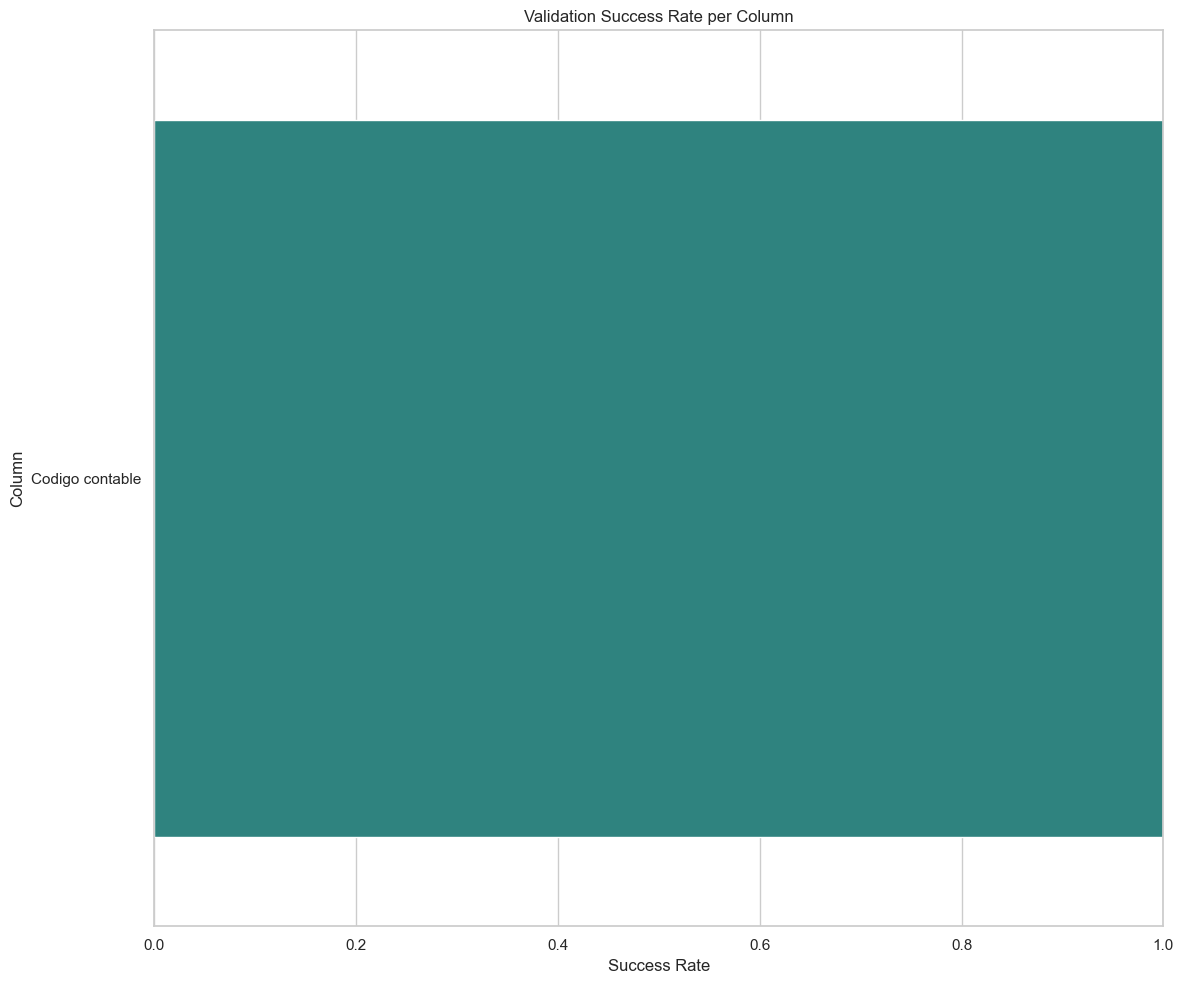

In [10]:
# 3. Success Rate per Column
success_per_column = df_validation.groupby(['column', 'success']).size().unstack(fill_value=0)

# Calculate the success rate, handling potential missing columns
success_per_column['success_rate'] = success_per_column.get(True, 0) / (success_per_column.get(True, 0) + success_per_column.get(False,0))

# Sort columns by success rate
success_per_column = success_per_column.sort_values(by='success_rate', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=success_per_column.reset_index(),
    x='success_rate',
    y='column',
    palette='viridis'
)
plt.title('Validation Success Rate per Column')
plt.xlabel('Success Rate')
plt.ylabel('Column')
plt.xlim(0,1)
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH,f"docs/validation_report/{data_asset_name}_{column}_success_rate_per_column.png"))
plt.show()

##### d. Unexpected Values Overview

/var/folders/76/q59sbk3j04d610g687pkcg2w0000gn/T/ipykernel_16207/4195673856.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


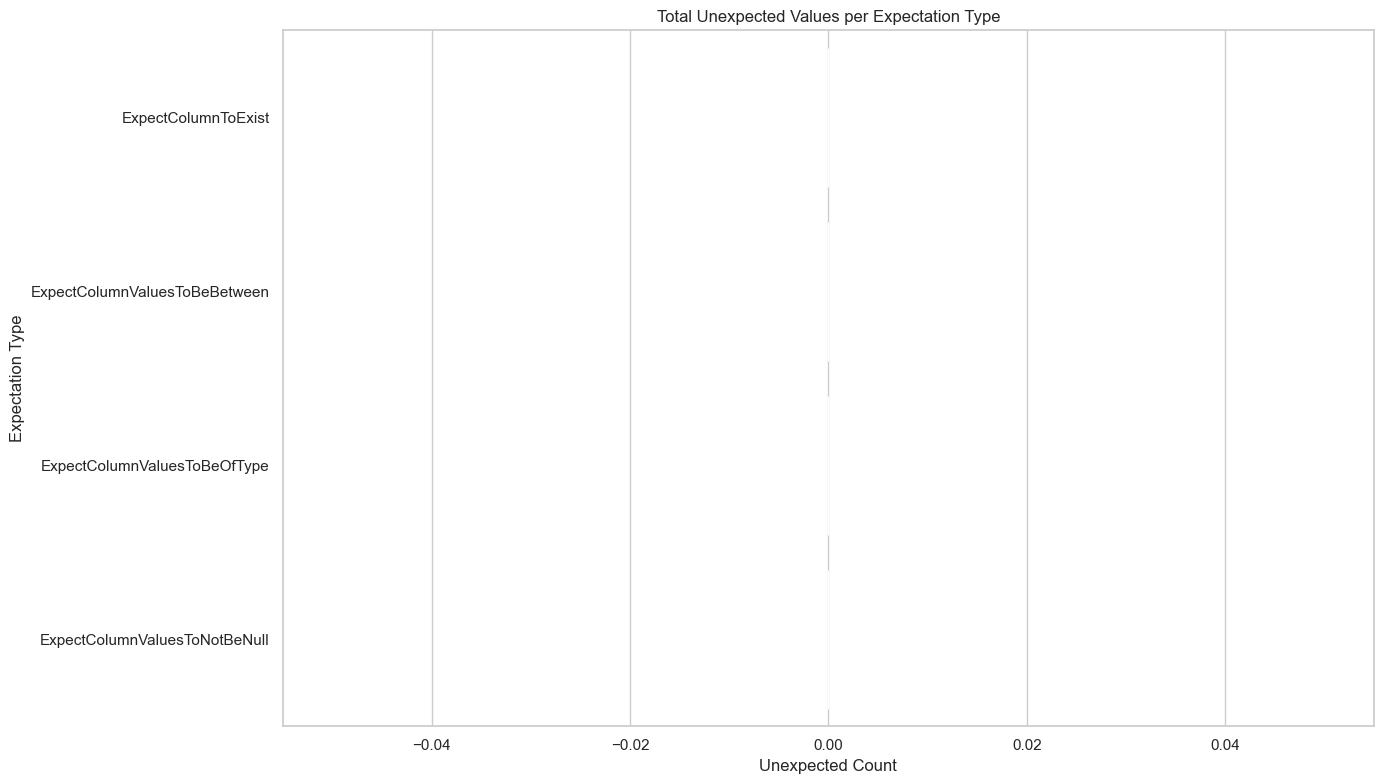

In [11]:
unexpected_counts = df_validation.groupby('expectation_type')['unexpected_count'].sum().reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(
    data=unexpected_counts,
    x='unexpected_count',
    y='expectation_type',
    palette='magma'
)
plt.title('Total Unexpected Values per Expectation Type')
plt.xlabel('Unexpected Count')
plt.ylabel('Expectation Type')
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH,f"docs/validation_report/{data_asset_name}_{column}_unexpected_values_overview.png"))
plt.show()

In [12]:
# Generate an HTML Report (Simplistic Example)
html_content = f"""
<html>
<head>
    <title>Data Validation Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; }}
        h1, h2 {{ color: #2F4F4F; }}
        table, th, td {{
            border: 1px solid black;
            border-collapse: collapse;
            padding: 8px;
        }}
        th {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <h1>Data Validation Report</h1>
    
    <h2>Summary Statistics</h2>
    {df_validation['success'].value_counts(normalize=True).to_frame().to_html()}
    
    <h2>Validation Results by Expectation Type</h2>
    <img src="validation_results_by_expectation_type.png" alt="Validation Results by Expectation Type">
    
    <h2>Overall Success Rate</h2>
    <img src="overall_success_rate.png" alt="Overall Success Rate">
    
    <h2>Success Rate per Column</h2>
    <img src="success_rate_per_column.png" alt="Success Rate per Column">
    
    <h2>Unexpected Values Overview</h2>
    <img src="unexpected_values_overview.png" alt="Unexpected Values Overview">
    
    <h2>Detailed Validation Results</h2>
    {df_validation.to_html(index=False)}
</body>
</html>
"""

# Write the HTML content to a file
with open(os.path.join(BASE_PATH,f"docs/validation_report/{data_asset_name}_{column}_validation_report.html"), "w") as f:
    f.write(html_content)

print("Validation report generated: validation_report.html")

Validation report generated: validation_report.html


# (END)